In [10]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from utils import *

In [74]:
X_train, y_train, X_test, y_test = load_data()

In [75]:
X_train = X_train.reshape((1000, -1)) / 255.0  # (1000, 4096) + Normalisation entre 0 et 1
X_test = X_test.reshape((200, -1)) / 255.0  # (200, 4096)

In [16]:
X_train.shape

(1000, 4096)

In [63]:
def initialisation(dimensions):
    
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1]) * np.sqrt(2 / dimensions[c - 1])
        parametres['b' + str(c)] = np.zeros((dimensions[c], 1))

    return parametres

In [4]:
def forward_propagation(X, parametres):
  
  activations = {'A0': X}

  C = len(parametres) // 2

  for c in range(1, C + 1):

    Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
    activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

  return activations

In [64]:
### Avec ReLU ###

def forward_propagation(X, parametres):
    activations = {'A0': X}
    C = len(parametres) // 2

    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['Z' + str(c)] = Z  # pour backpropagation

        if c == C:
            # dernière couche : sigmoïde
            A = 1 / (1 + np.exp(-Z))
        else:
            # couche cachée : ReLU
            A = np.maximum(0, Z)

        activations['A' + str(c)] = A

    return activations


In [5]:
def back_propagation(y, parametres, activations):

  m = y.shape[1]
  C = len(parametres) // 2

  dZ = activations['A' + str(C)] - y
  gradients = {}

  for c in reversed(range(1, C + 1)):
    gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
    gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    if c > 1:
      dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

  return gradients

In [65]:
### Avec ReLU ###

def back_propagation(y, parametres, activations):

    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)

        if c > 1:
            dA = np.dot(parametres['W' + str(c)].T, dZ)
            Z_prev = activations['Z' + str(c - 1)]
            dZ = dA * (Z_prev > 0)  # dérivée de ReLU

    return gradients


In [67]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [68]:
def predict(X, parametres):
    activations = forward_propagation(X.T, parametres)  # X.T si X est (n_samples, n_features)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return (Af >= 0.5).astype(int).T  # .T pour revenir à la forme (n_samples, 1)


In [46]:
X_train.T.shape

(4096, 1000)

In [69]:
def deep_neural_network(X, y, hidden_layers = (32, 32, 32), learning_rate = 0.01, n_iter = 3000):
    
    X = X.T
    y = y.T
    print("X shape:", X.shape)

    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(1)
    np.random.seed(1)
    parametres = initialisation(dimensions)

    # tableau numpy contenant les futures accuracy et log_loss
    training_history = np.zeros((int(n_iter), 2))

    C = len(parametres) // 2

    # gradient descent
    for i in tqdm(range(n_iter)):

        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]

        # calcul du log_loss et de l'accuracy
        training_history[i, 0] = (log_loss(y.flatten(), Af.flatten()))
        y_pred = predict(X.T, parametres)
        training_history[i, 1] = (accuracy_score(y.flatten(), y_pred.flatten()))

    # Plot courbe d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_history[:, 1], label='train acc')
    plt.legend()
    plt.show()

    return training_history, parametres


X shape: (4096, 1000)


100%|██████████| 4000/4000 [01:24<00:00, 47.39it/s]


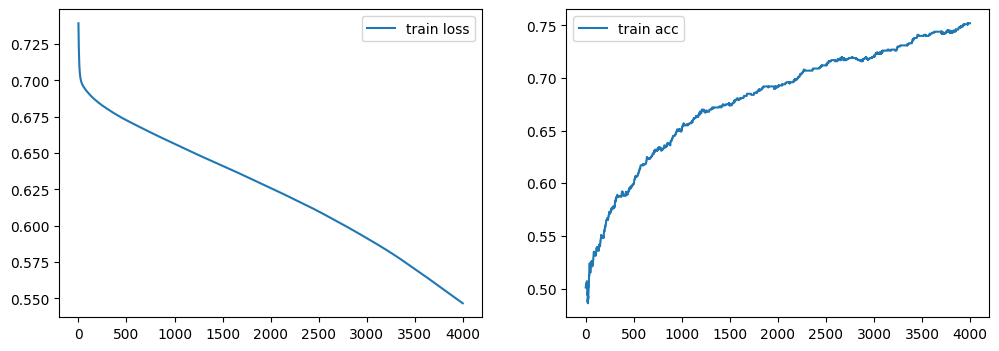

In [70]:
history, parametres = deep_neural_network(X_train, y_train, hidden_layers=(128,64,32), learning_rate=0.001, n_iter=4000)


In [72]:
y_test_pred = predict(X_test, parametres)

In [76]:
from sklearn.metrics import accuracy_score, log_loss

# Évaluation
acc = accuracy_score(y_test.flatten(), y_test_pred.flatten())
loss = log_loss(y_test.flatten(), y_test_pred.flatten())

print(f"Test accuracy: {acc:.4f}")
print(f"Test log loss: {loss:.4f}")


Test accuracy: 0.6300
Test log loss: 13.3362
